# Quantifiably measure the preformance of the greedy heuristic algorithm

In [1]:
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from itertools import permutations
from math import factorial, log
from time import time

from xmlparse import loadRef, loadGeometryBases, getXmlScore, minXml, loadScores
from score_strokes import alignStrokes, greedyAlign2
from exhaustive import computeExhaustive, exhaustScore, exhaustScoreAlignment



2023-10-24T19:17:55.927034Z [INFO ] Stylus initialized - Stylus 1.5.0 [RELEASE - Aug 29 2023 15:40:46] (c) 2006-2009 Biologic Institute


In [2]:
def matchError(heuristic, ref_char, char_data, data_dir="HanBitmap", exhaustive_scores=True, timed=False, mode="max", times_exhaustive=[], xml_dir="GenXml"):
    """
    Inputs:
    heuristic: function to test
    han_char: arctype to test against
    char_data: mutated character data to test

    Error is calculated as log(original_score/heuristic_score, 2) (log base 2)
    This demonstrates the difference in magnitude between the scores,
    which in this context is more relevant that absolute differene
    The log is neccesary to keep numbers from growing obscenely large
    """
    # load in reference geometry
    ref_g, ref_l, output_size = loadRef(ref_char, "Reference")
    # parse character data
    g_data, han_chars, base_data, stroke_sets, stroke_orders, f_names = char_data
    errors = []
    times_heuristic = []
    heuristic_alignments = []
    heuristic_scores = []
    time_store = 0.0
    error_sum = 0.0
    error_max = 0.0
    error_min = np.inf
    if exhaustive_scores==True:
        exhaustive_scores = []
        times_exhaustive = []
        exhaustive_scores, times_exhaustive = matchExhaustive(ref_char, char_data, data_dir, timed)
    for (gl, han_char, bases, stroke_set, stroke_order, f_name, i) in zip(g_data, han_chars, base_data, stroke_sets, stroke_orders, f_names, range(len(g_data))):
        g, l = gl
        heuristic_alignment = np.array(alignStrokes(g, ref_g, l, ref_l, mode=mode))+1#np.array([0, 3, 5, 4, 1, 2])+1
        heuristic_alignments.append(heuristic_alignment)
        heuristic_xml = minXml(ref_char, bases, stroke_set, heuristic_alignment)
        # time for heuristic - stored in times_heuristic
        time_store = time()
        heuristic_score = getXmlScore(heuristic_xml, save_xml=f"{xml_dir}/{i}_{f_name}", save_min=f"{xml_dir}/{i}_min_{f_name}")
        heuristic_scores.append(heuristic_score)
        times_heuristic.append(time()-time_store)
            #original_xml = minXml(han_char, bases, stroke_set, stroke_order)
            #original_score = getXmlScore(original_xml)
        original_score = exhaustive_scores[i]
        if f_name == "4EFB.2.19.gene":
            print(f"Exhaustive: {exhaustive_scores[i]}, Heuristic: {heuristic_score}")
        error = (heuristic_score)#log(original_score/heuristic_score, 2)
        errors.append(error)
        error_sum += error
        if error > error_max:
            error_max = error
        if error < error_min:
            error_min = error
    error_avg = error_sum/len(g_data)
    print(f"Max Error for pair: {error_max}\nMin Error for set: {error_min}\nAvg Error for set: {error_avg}")
    return errors, times_heuristic, times_exhaustive, heuristic_alignments, heuristic_scores, f_names

def matchExhaustive(ref_char, char_data, data_dir, timed=False):
    ref_g, ref_l, output_size = loadRef(ref_char, "Reference")
    g_data, han_chars, base_data, stroke_sets, stroke_orders, f_names = char_data
    exhaustive_scores = []
    times_exhaustive = []
    for (gl, han_char, bases, stroke_set, stroke_order, f_name) in zip(g_data, han_chars, base_data, stroke_sets, stroke_orders, f_names):
        g, l = gl
        if timed:
            time_store = time()
            original_score = exhaustScore(ref_char, han_char, f_name, data_dir, force_refresh = True, save = False)
            times_exhaustive.append(time()-time_store)
        else:
            original_score = exhaustScore(ref_char, han_char, f_name, data_dir, mode=mode)
        exhaustive_scores.append(original_score)
    return exhaustive_scores, times_exhaustive

def matchExhaustiveAlignments(ref_char, char_data, data_dir):
    ref_g, ref_l, output_size = loadRef(ref_char, "Reference")
    g_data, han_chars, base_data, stroke_sets, stroke_orders, f_names = char_data
    exhaustive_scores = []
    times_exhaustive = []
    for (gl, han_char, bases, stroke_set, stroke_order, f_name) in zip(g_data, han_chars, base_data, stroke_sets, stroke_orders, f_names):
        g, l = gl
        exhaustive_alignment = exhaustScoreAlignment(ref_char, han_char, f_name, data_dir, mode=mode)
        exhaustive_scores.append(original_score)
    return exhaustive_scores, times_exhaustive

Exhaustive: 0.006953499260843087, Heuristic: 3.262967762022197e-09
Max Error for pair: 0.0060969805581373
Min Error for set: 5.721279709132352e-13
Avg Error for set: 0.00037084673369736424
0.00037084673369736424
0.0003448486328125
0.23630821704864502
20
4EFB.2.19.gene


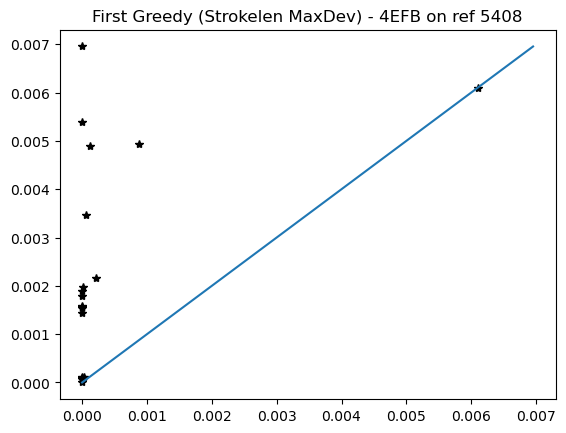

In [3]:
root_dir = "Genes/sixgenes"
child_dir = "maint_0.2 on 4EFB.2"
data_dir = f"{root_dir}/{child_dir}"
child_han = child_dir.split()[2].split(".")[0]

graphs_dir = "Graphs"
xml_dir = "GenXml"

han_char = "5408"
ref_g, ref_l, output_size = loadRef(han_char, "Reference")
char_data = loadGeometryBases(data_dir, output_size)

heuristic = alignStrokes
scores = loadScores(data_dir, han_char)
mode="max"
exhaustive_scores, times_exhaustive = matchExhaustive(han_char, char_data, data_dir, timed=True)
errors, t_h, t_e, heuristic_alignments, heuristic_scores, f_names = matchError(heuristic, han_char, char_data, data_dir, exhaustive_scores, timed=True, mode=mode, times_exhaustive=times_exhaustive, xml_dir=xml_dir)

print(sum(errors)/len(errors))
print(sum(t_h)/len(t_h))
print(sum(t_e)/len(t_e))
print(len(t_e))
#plt.hist(errors)
#plt.hist(exhaustives)
print(f_names[np.argmax(exhaustive_scores)])
plt.plot(heuristic_scores, exhaustive_scores, "k*")
plt.plot([0, max(exhaustive_scores)], [0, max(exhaustive_scores)])
plt.title(f"First Greedy (Strokelen MaxDev) - {child_han} on ref {han_char}")
plt.savefig(f"{graphs_dir}/greedy1_max_{child_han}on{han_char}.png")

# note that the below error is huge - it is only log scaled to be readable
# it represents a 2^error difference in magnitude between the ideal order score and heuristic order score
# the way error is currently calculated, it would need to be very small, very consistenly to be 'insignificant'
# as it is, performance probably shouldn't be acceptable unless error is fractional (<1)

# TODO: investigate 56DB.08.46.gene, which had a heuristic score greater than its actual Stylus score

In [4]:
xml_dir = "GenXml"
xml_names = [f"{xml_dir}/{i}_{f_name}" for (i, f_name) in enumerate(f_names)]
min_names = [f"{xml_dir}/{i}_min_{f_name}" for (i, f_name) in enumerate(f_names)]
table = pd.DataFrame({"Xml": xml_names, "MinXml": min_names, "Heuristic Alignments": heuristic_alignments, "Heuristic Scores": heuristic_scores, "Exhaustive Scores": exhaustive_scores})
table

,Xml,MinXml,Heuristic Alignments,Heuristic Scores,Exhaustive Scores
0,GenXml/0_4EFB.2.1.gene,GenXml/0_min_4EFB.2.1.gene,"[1, 4, 5, 3, 2, 6]",2.973170e-09,0.000007
1,GenXml/1_4EFB.2.10.gene,GenXml/1_min_4EFB.2.10.gene,"[1, 4, 5, 3, 2, 6]",2.518554e-12,0.001888
2,GenXml/2_4EFB.2.7.gene,GenXml/2_min_4EFB.2.7.gene,"[1, 4, 5, 3, 2, 6]",2.911911e-06,0.001787
3,GenXml/3_4EFB.2.18.gene,GenXml/3_min_4EFB.2.18.gene,"[1, 6, 5, 4, 3, 2]",1.466466e-07,0.005384
4,GenXml/4_4EFB.2.9.gene,GenXml/4_min_4EFB.2.9.gene,"[1, 4, 5, 3, 2, 6]",4.598814e-12,0.000088
5,GenXml/5_4EFB.2.16.gene,GenXml/5_min_4EFB.2.16.gene,"[1, 6, 5, 4, 3, 2]",3.692809e-10,0.001549
6,GenXml/6_4EFB.2.2.gene,GenXml/6_min_4EFB.2.2.gene,"[1, 3, 5, 4, 2, 6]",7.785115e-08,0.001447
7,GenXml/7_4EFB.2.20.gene,GenXml/7_min_4EFB.2.20.gene,"[1, 4, 5, 3, 2, 6]",1.195905e-10,0.000080
8,GenXml/8_4EFB.2.4.gene,GenXml/8_min_4EFB.2.4.gene,"[1, 4, 5, 3, 2, 6]",2.862863e-05,0.000108
9,GenXml/9_4EFB.2.3.gene,GenXml/9_min_4EFB.2.3.gene,"[1, 4, 5, 3, 2, 6]",9.046633e-06,0.001968


Exhaustive: 0.006953499260843087, Heuristic: 9.109300706708833e-05
Max Error for pair: 0.001201797567037238
Min Error for set: 2.011828535376936e-16
Avg Error for set: 8.805689632030373e-05
8.805689632030373e-05
0.0003569602966308594
0.23463426828384398
20


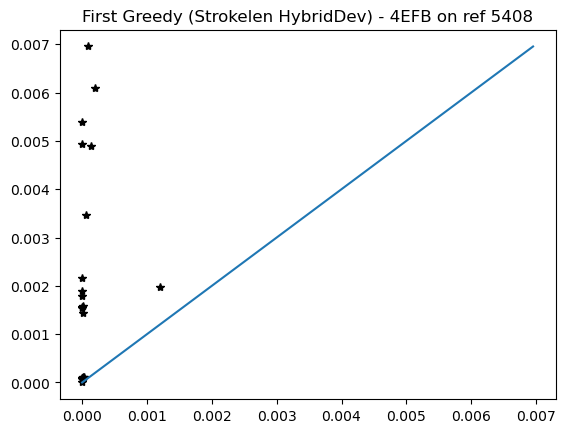

In [5]:
mode="hybrid"

exhaustive_scores, times_exhaustive = matchExhaustive(han_char, char_data, data_dir, timed=True)
errors, t_h, t_e, heuristic_alignments, heuristic_scores, f_names = matchError(heuristic, han_char, char_data, data_dir, timed=True, mode=mode, times_exhaustive=times_exhaustive)

print(sum(errors)/len(errors))
print(sum(t_h)/len(t_h))
print(sum(t_e)/len(t_e))
print(len(t_e))
#plt.hist(errors)
#plt.hist(exhaustives)
max_exhaustive = np.argmax(exhaustive_scores)
plt.plot(errors, exhaustive_scores, "k*")
plt.plot([0, max(exhaustive_scores)], [0, max(exhaustive_scores)])
plt.title(f"First Greedy (Strokelen HybridDev) - {child_han} on ref {han_char}")
plt.savefig(f"{graphs_dir}/greedy1_avg_{child_han}on{han_char}.png")


In [6]:
max_exhaustive = 13
g_data, han_chars, base_data, stroke_sets, stroke_orders, f_names = char_data
print(exhaustScoreAlignment(han_char, han_chars[max_exhaustive], f_names[max_exhaustive], data_dir))

Wrote exhaustive scores to Exhaustive/exhaust_5408_4EFB_4EFB.2.19.gene.npy
(1, 4, 3, 5, 2, 6)


Exhaustive: 0.006953499260843087, Heuristic: 3.262967762022197e-09
Max Error for pair: 0.0060969805581373
Min Error for set: 5.721279709132352e-13
Avg Error for set: 0.00037084673369736424
0.00037084673369736424
0.0003383398056030273
0.23468269109725953
20


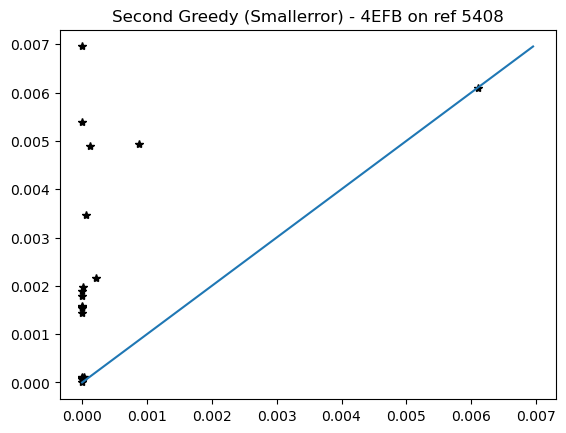

In [7]:
plt.clf()
heuristic = greedyAlign2

errors, t_h, t_e, heuristic_alignments, heuristic_scores, f_names = matchError(heuristic, han_char, char_data, data_dir, timed=True, )

print(sum(errors)/len(errors))
print(sum(t_h)/len(t_h))
print(sum(t_e)/len(t_e))
print(len(t_e))
#plt.hist(errors)
#plt.hist(exhaustives)
#np.argmax(exhaustives)
plt.plot(errors, exhaustive_scores, "k*")
plt.plot([0, max(exhaustive_scores)], [0, max(exhaustive_scores)])
plt.title(f"Second Greedy (Smallerror) - {child_han} on ref {han_char}")
plt.savefig(f"{graphs_dir}/greedy2_{child_han}on{han_char}.png")

In [8]:
"""
f_read = ["56DB.08.46.gene"]
ref_char = "56DB"
han_char = "56DB"
data_dir = "Genes/maint_0.001 on 56DB.08/"
exhaustScore(ref_char, han_char, f_read[0], data_dir, force_refresh=True, save=False)
"""
# this confirms that, in this case, greedy found the 'correct' exhaustive solution even when Stylus didn't have it by default

'\nf_read = ["56DB.08.46.gene"]\nref_char = "56DB"\nhan_char = "56DB"\ndata_dir = "Genes/maint_0.001 on 56DB.08/"\nexhaustScore(ref_char, han_char, f_read[0], data_dir, force_refresh=True, save=False)\n'